# Gaia 3D星図マップの作成

## 目的
Gaiaデータセットから星の3次元位置を計算し、可視化する。

## 学習内容
1. 天球座標（赤経・赤緯）から直交座標への変換
2. 視差から距離への変換
3. 3Dプロットの作成

In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 日本語表示設定
plt.rcParams['font.size'] = 12

## 1. データの読み込み

In [2]:
# Parquetファイルの読み込み
df = pd.read_parquet('../dataset/train-00000-of-00001.parquet')

print(f"データ数: {len(df)}")
print(f"\nカラム: {df.columns.tolist()}")
df.head()

データ数: 100000

カラム: ['spectral_coefficients', 'photometry', 'astrometry', 'radial_velocity', 'gspphot', 'flags', 'corrections', 'object_id', 'healpix', 'ra', 'dec']


,spectral_coefficients,photometry,astrometry,radial_velocity,gspphot,flags,corrections,object_id,healpix,ra,dec
0,"{'coeff': [102.93399, -12.336921, -2.6688561, ...","{'phot_g_mean_mag': 17.64142608642578, 'phot_g...","{'ra': 44.99615478515625, 'ra_error': 0.101618...","{'radial_velocity': nan, 'radial_velocity_erro...","{'ag_gspphot': 0.005200000014156103, 'ag_gspph...",{'ruwe': 1.1429516077041626},"{'ecl_lat': -16.329574584960938, 'ecl_lon': 42...",4295806720,0,44.996155,0.005615
1,"{'coeff': [2464.6943, -16.53426, -103.747856, ...","{'phot_g_mean_mag': 14.128453254699707, 'phot_...","{'ra': 45.00497817993164, 'ra_error': 0.017885...","{'radial_velocity': 41.18717575073242, 'radial...","{'ag_gspphot': 0.18199999630451202, 'ag_gsppho...",{'ruwe': 1.0121910572052002},"{'ecl_lat': -16.31852149963379, 'ecl_lon': 42....",38655544960,0,45.004978,0.019880
2,"{'coeff': [381.396, -38.64146, -9.373882, 4.42...","{'phot_g_mean_mag': 16.236270904541016, 'phot_...","{'ra': 44.99327087402344, 'ra_error': 0.044207...","{'radial_velocity': nan, 'radial_velocity_erro...","{'ag_gspphot': 0.0031999999191612005, 'ag_gspp...",{'ruwe': 1.0098440647125244},"{'ecl_lat': -16.26111602783203, 'ecl_lon': 42....",1275606125952,0,44.993271,0.076334
3,"{'coeff': [432.96344, -87.38492, 7.8807244, -1...","{'phot_g_mean_mag': 16.148805618286133, 'phot_...","{'ra': 44.996063232421875, 'ra_error': 0.04317...","{'radial_velocity': nan, 'radial_velocity_erro...","{'ag_gspphot': 0.25119999051094055, 'ag_gsppho...",{'ruwe': 1.0308148860931396},"{'ecl_lat': -16.253726959228516, 'ecl_lon': 42...",1653563247744,0,44.996063,0.084918
4,"{'coeff': [14257.696, -2552.2078, 70.903885, 5...","{'phot_g_mean_mag': 12.356247901916504, 'phot_...","{'ra': 45.132144927978516, 'ra_error': 0.01758...","{'radial_velocity': 36.31719207763672, 'radial...","{'ag_gspphot': 0.10490000247955322, 'ag_gsppho...",{'ruwe': 1.2133009433746338},"{'ecl_lat': -16.242931365966797, 'ecl_lon': 42...",2851858288640,0,45.132145,0.137854


## 2. データのフィルタリング

In [3]:
def print_validation_report(report):
    """
    バリデーション結果のレポートを表示する
    
    Parameters:
    -----------
    report : dict
        バリデーション結果のレポート
    """
    print("\n" + "="*50)
    print("データバリデーション結果")
    print("="*50)
    print(f"総データ数: {report['total_records']:,}件")
    print(f"有効データ数: {report['valid_records']:,}件")
    print(f"除外データ数: {report['total_removed']:,}件")
    print(f"データ保持率: {report['retention_rate']:.2f}%")
    
    if report['removed']:
        print("\n除外理由の内訳:")
        for reason, count in report['removed'].items():
            percentage = (count / report['total_records']) * 100
            print(f"  - {reason}: {count:,}件 ({percentage:.2f}%)")
    print("="*50)

def validate_gaia_data(df, verbose=True):
    """
    Gaiaデータの品質チェックと有効なデータの抽出
    
    Parameters:
    -----------
    df : pd.DataFrame
        Gaiaデータセット
    verbose : bool, default=True
        詳細なレポートを表示するかどうか
        
    Returns:
    --------
    df_valid : pd.DataFrame
        有効なデータのみを含むDataFrame
    validation_report : dict
        バリデーション結果のレポート
    """
    
    validation_report = {
        'total_records': len(df),
        'removed': {}
    }
    
    # 初期データ
    df_valid = df.copy()
    initial_count = len(df_valid)
    
    # 1. 必須フィールドの欠損値チェック
    required_fields = [
        ('astrometry', 'ra'),
        ('astrometry', 'dec'),
        ('astrometry', 'parallax'),
        ('astrometry', 'parallax_error'),
        ('photometry', 'phot_g_mean_mag')
    ]
    
    for parent, field in required_fields:
        null_mask = df_valid[parent].apply(lambda x: pd.isna(x.get(field)) if isinstance(x, dict) else True)
        null_count = null_mask.sum()
        if null_count > 0:
            validation_report['removed'][f'{parent}.{field}_null'] = null_count
            df_valid = df_valid[~null_mask].copy()
    
    # 2. 視差が正の値のみ
    negative_parallax_mask = df_valid['astrometry'].apply(lambda x: x.get('parallax', 0) if isinstance(x, dict) else 0) <= 0
    negative_count = negative_parallax_mask.sum()
    if negative_count > 0:
        validation_report['removed']['negative_or_zero_parallax'] = negative_count
        df_valid = df_valid[~negative_parallax_mask].copy()
    
    # 3. 視差の精度チェック（視差 > 3 * 視差エラー）
    # S/N比が3以上のデータのみを使用
    parallax_values = df_valid['astrometry'].apply(lambda x: x.get('parallax', 0) if isinstance(x, dict) else 0)
    parallax_error_values = df_valid['astrometry'].apply(lambda x: x.get('parallax_error', float('inf')) if isinstance(x, dict) else float('inf'))
    low_precision_mask = parallax_values <= 3 * parallax_error_values
    low_precision_count = low_precision_mask.sum()
    if low_precision_count > 0:
        validation_report['removed']['low_precision_parallax'] = low_precision_count
        df_valid = df_valid[~low_precision_mask].copy()
    
    # 4. 異常値のチェック（視差が極端に大きい/小さい）
    # 視差が1000 mas（距離1pc）以上 または 0.1 mas（距離10kpc）以下を除外
    parallax_values = df_valid['astrometry'].apply(lambda x: x.get('parallax', 0) if isinstance(x, dict) else 0)
    extreme_parallax_mask = (parallax_values > 1000) | (parallax_values < 0.1)
    extreme_count = extreme_parallax_mask.sum()
    if extreme_count > 0:
        validation_report['removed']['extreme_parallax'] = extreme_count
        df_valid = df_valid[~extreme_parallax_mask].copy()
    
    validation_report['valid_records'] = len(df_valid)
    validation_report['total_removed'] = initial_count - len(df_valid)
    validation_report['retention_rate'] = len(df_valid) / initial_count * 100 if initial_count > 0 else 0
    
    if verbose:
        print_validation_report(validation_report)
    
    return df_valid, validation_report

df_valid, report = validate_gaia_data(df)

# 視差が正で、エラーが小さいデータのみを使用
df_filtered = df_valid.copy()

print(f"フィルタ後のデータ数: {len(df_filtered)}")


データバリデーション結果
総データ数: 100,000件
有効データ数: 92,156件
除外データ数: 7,844件
データ保持率: 92.16%

除外理由の内訳:
  - astrometry.parallax_null: 613件 (0.61%)
  - photometry.phot_g_mean_mag_null: 1件 (0.00%)
  - negative_or_zero_parallax: 813件 (0.81%)
  - low_precision_parallax: 6,318件 (6.32%)
  - extreme_parallax: 99件 (0.10%)
フィルタ後のデータ数: 92156


## 3. 座標変換関数の定義

In [4]:
def parallax_to_distance(parallax_mas):
    """視差[mas]から距離[pc]を計算"""
    return 1000.0 / parallax_mas

def equatorial_to_cartesian(ra_deg, dec_deg, distance_pc):
    """赤道座標系から直交座標系へ変換"""
    ra_rad = np.radians(ra_deg)
    dec_rad = np.radians(dec_deg)
    
    x = distance_pc * np.cos(dec_rad) * np.cos(ra_rad)
    y = distance_pc * np.cos(dec_rad) * np.sin(ra_rad)
    z = distance_pc * np.sin(dec_rad)
    
    return x, y, z

## 4. 距離と直交座標の計算

In [5]:
import numpy as np
import pandas as pd

# 1. 計算に必要な値を一時的なDataFrameとして抽出（高速）
# tolist()を使って一括でリスト化してからDataFrameにすると、applyより格段に速いです
temp_astro = pd.DataFrame(df_filtered['astrometry'].tolist())

# 2. numpy配列として変数を確保（計算用）
# 元のdf_filteredのインデックスとずれないように注意が必要ですが、
# tolist()経由なら順序は保たれます
ra_deg = temp_astro['ra'].values
dec_deg = temp_astro['dec'].values
parallax_mas = temp_astro['parallax'].values

# 3. 距離の計算 (d[pc] = 1000 / parallax[mas])
# ゼロ除算や負の値を防ぐため、無効な値は NaN にします
with np.errstate(divide='ignore', invalid='ignore'):
    distance_pc = 1000.0 / parallax_mas
    # 負の視差や0は距離として定義できないため NaN に置き換え
    distance_pc[distance_pc <= 0] = np.nan

# 4. 直交座標への変換
# 角度をラジアンに変換
ra_rad = np.deg2rad(ra_deg)
dec_rad = np.deg2rad(dec_deg)


# 変換式
# x = r * cos(dec) * cos(ra)
# y = r * cos(dec) * sin(ra)
# z = r * sin(dec)
x = distance_pc * np.cos(dec_rad) * np.cos(ra_rad)
y = distance_pc * np.cos(dec_rad) * np.sin(ra_rad)
z = distance_pc * np.sin(dec_rad)

# 5. 結果を元の df_filtered に新しい列として追加
# ここで初めて df_filtered を更新します（構造破壊ではなく列追加）
df_filtered['distance_pc'] = distance_pc
df_filtered['x'] = x
df_filtered['y'] = y
df_filtered['z'] = z

# 結果の確認
print(f"距離範囲: {df_filtered['distance_pc'].min():.1f} ~ {df_filtered['distance_pc'].max():.1f} pc")
print("追加された列:", ['distance_pc', 'x', 'y', 'z'])

距離範囲: 7.6 ~ 9970.7 pc
追加された列: ['distance_pc', 'x', 'y', 'z']


## 5. 3D散布図の作成

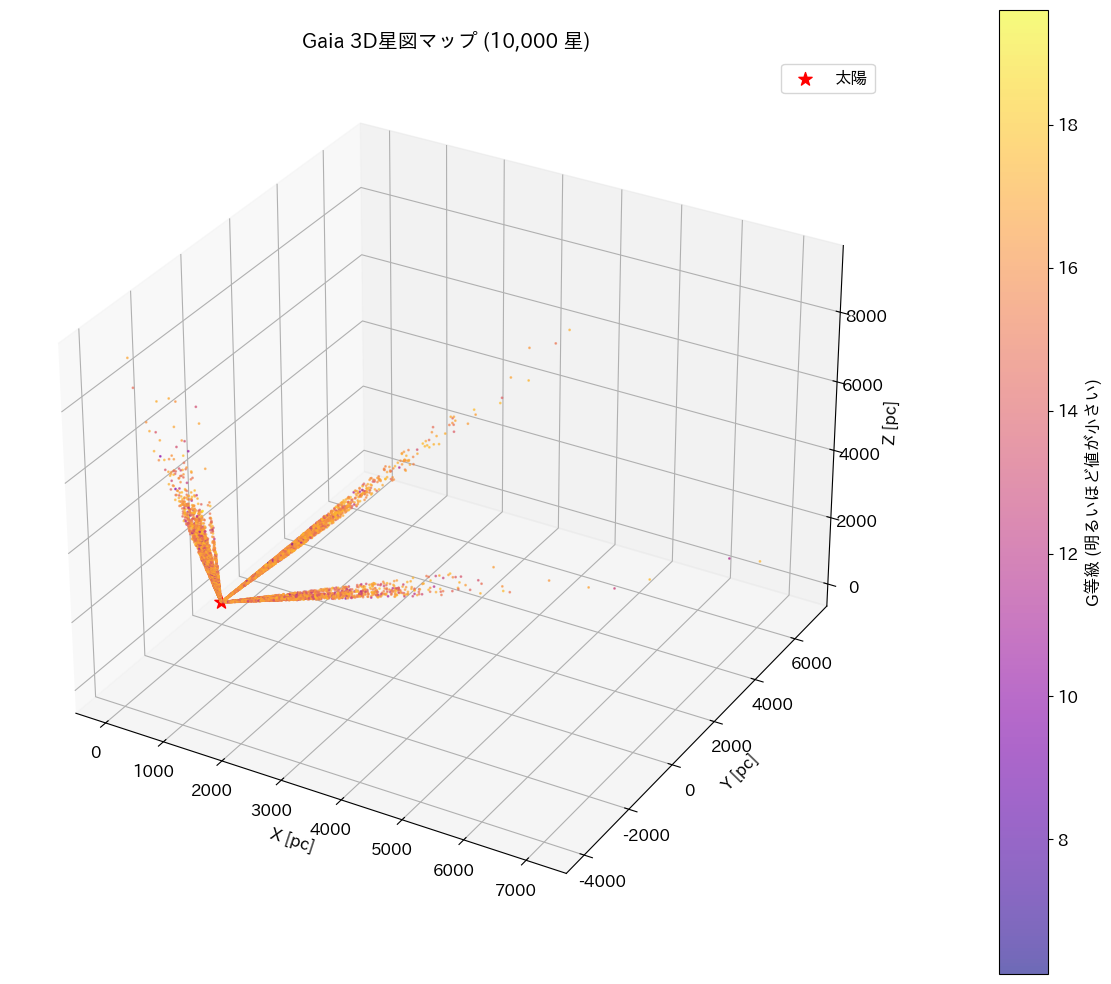

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# コンテナにインストールしたフォントのパスまたは名前を指定
# IPAexGothic または IPAexMincho が利用可能です
# 多くの環境で 'IPAexGothic' が安定して使用できます

# 1. 使用するフォント名を設定
FONT_NAME = "IPAexGothic"

# 3. rcParamsでフォントファミリーを設定
plt.rcParams['font.family'] = FONT_NAME
plt.rcParams['font.sans-serif'] = [FONT_NAME]
plt.rcParams['axes.unicode_minus'] = False # 負の符号（-）を正しく表示するために必要

# 前提: df_filtered には 'x', 'y', 'z' 列がすでに追加されているものとします。

# --- 1. G等級の値を一時的に抽出 ---
# photometry 列から 'phot_g_mean_mag' の値を効率的に抽出します。
temp_photometry = pd.DataFrame(df_filtered['photometry'].tolist())
g_mag_series = temp_photometry['phot_g_mean_mag']

# 抽出したG等級を df_filtered に追加（プロットを容易にするため）
df_filtered['phot_g_mean_mag_clean'] = g_mag_series

# --- 2. サンプリングとクリーンアップ ---
# 距離やG等級が NaN のデータをここで除外してプロットエラーを防ぎます。
df_plot = df_filtered.dropna(subset=['x', 'y', 'z', 'phot_g_mean_mag_clean'])

sample_size = min(10000, len(df_plot))
df_sample = df_plot.sample(n=sample_size, random_state=42)

# --- 3. 3Dプロット ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_sample['x'],
    df_sample['y'],
    df_sample['z'],
    # 抽出したクリーンな列を使用
    c=df_sample['phot_g_mean_mag_clean'],
    cmap='plasma',
    s=1,
    alpha=0.6
)

# 太陽の位置をプロット
ax.scatter([0], [0], [0], c='red', s=100, marker='*', label='太陽', zorder=10) # zorderで最前面に

# ラベルとタイトル
ax.set_xlabel('X [pc]')
ax.set_ylabel('Y [pc]')
ax.set_zlabel('Z [pc]')
ax.set_title(f'Gaia 3D星図マップ ({sample_size:,} 星)')

# カラーバーの追加 (G等級が暗いほど明るい色になるよう cmap='viridis_r' を使用)
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('G等級 (明るいほど値が小さい)')

ax.legend()
plt.tight_layout()
plt.show()

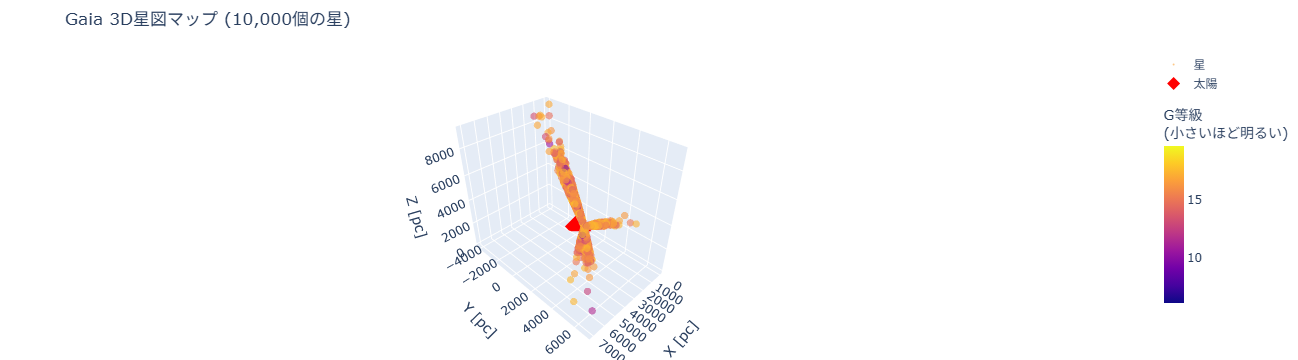

In [7]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# --- 1. G等級の値を一時的に抽出 ---
# photometry 列から 'phot_g_mean_mag' の値を効率的に抽出します。
temp_photometry = pd.DataFrame(df_filtered['photometry'].tolist())
g_mag_series = temp_photometry['phot_g_mean_mag']

# 抽出したG等級を df_filtered に追加（プロットを容易にするため）
df_filtered['phot_g_mean_mag_clean'] = g_mag_series

# --- 2. サンプリングとクリーンアップ ---
# 距離やG等級が NaN のデータをここで除外してプロットエラーを防ぎます。
df_plot = df_filtered.dropna(subset=['x', 'y', 'z', 'phot_g_mean_mag_clean'])

sample_size = min(10000, len(df_plot))
df_sample = df_plot.sample(n=sample_size, random_state=42)

# --- 3. 距離を計算（ホバー表示用） ---
df_sample['distance'] = np.sqrt(
    df_sample['x']**2 + 
    df_sample['y']**2 + 
    df_sample['z']**2
)

# --- 4. ホバーテキストを作成 ---
hover_text = []
for idx, row in df_sample.iterrows():
    text = (
        f"ID: {row.get('source_id', 'N/A')}<br>"
        f"G等級: {row['phot_g_mean_mag_clean']:.2f}<br>"
        f"距離: {row['distance']:.2f} pc<br>"
        f"座標: ({row['x']:.2f}, {row['y']:.2f}, {row['z']:.2f})"
    )
    hover_text.append(text)

# --- 5. 星のトレースを作成 ---
trace_stars = go.Scatter3d(
    x=df_sample['x'],
    y=df_sample['y'],
    z=df_sample['z'],
    mode='markers',
    name='星',
    marker=dict(
        size=2,
        color=df_sample['phot_g_mean_mag_clean'],
        colorscale='Plasma',
        colorbar=dict(
            title='G等級<br>(小さいほど明るい)',
            thickness=20,
            len=0.7
        ),
        opacity=0.6,
        showscale=True
    ),
    text=hover_text,
    hoverinfo='text'
)

# --- 6. 太陽のトレースを作成 ---
trace_sun = go.Scatter3d(
    x=[0],
    y=[0],
    z=[0],
    mode='markers',
    name='太陽',
    marker=dict(
        size=10,
        color='red',
        symbol='diamond'
    ),
    text=['太陽 (0, 0, 0)'],
    hoverinfo='text'
)

# --- 7. レイアウトを設定 ---
layout = go.Layout(
    title=f'Gaia 3D星図マップ ({sample_size:,}個の星)',
    scene=dict(
        xaxis=dict(title='X [pc]'),
        yaxis=dict(title='Y [pc]'),
        zaxis=dict(title='Z [pc]'),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        )
    ),
    showlegend=True,
    hovermode='closest',
    margin=dict(l=0, r=0, t=50, b=0)
)

# --- 8. フィギュアを作成して表示 ---
fig = go.Figure(data=[trace_stars, trace_sun], layout=layout)

# Notebookで表示
fig.show()

# オプション: HTMLファイルとして保存したい場合
# fig.write_html("gaia_3d_map.html")

In [8]:
from vpython import *
import numpy as np
import pandas as pd

# ----------------------------------------------------------------------
# データの準備（このブロックは、前の処理で完了している想定です）
# 実行前に df_filtered と phot_g_mean_mag_clean が存在している必要があります
# ----------------------------------------------------------------------
# 仮のデータ作成 (実際に使用する際は、このブロックは不要です)
# if 'df_filtered' not in locals():
#     print("ダミーデータを作成しています。")
#     data_size = 5000
#     ra_rand = np.random.uniform(0, 360, data_size)
#     dec_rand = np.random.uniform(-90, 90, data_size)
#     dist_rand = np.random.lognormal(2, 0.5, data_size)
#     g_mag_rand = np.random.uniform(10, 20, data_size)

#     df_filtered = pd.DataFrame({
#         'x': dist_rand * np.cos(np.deg2rad(dec_rand)) * np.cos(np.deg2rad(ra_rand)),
#         'y': dist_rand * np.cos(np.deg2rad(dec_rand)) * np.sin(np.deg2rad(ra_rand)),
#         'z': dist_rand * np.sin(np.deg2rad(dec_rand)),
#         'phot_g_mean_mag_clean': g_mag_rand,
#         'distance_pc': dist_rand
#     })

# --- 2. サンプリングとクリーンアップ ---
# 距離やG等級が NaN のデータをここで除外してプロットエラーを防ぎます。
df_plot = df_filtered.dropna(subset=['x', 'y', 'z', 'phot_g_mean_mag_clean'])

# 処理時間を考慮し、サンプリングサイズを調整 (最大10,000件)
sample_size = min(10000, len(df_plot))
df_sample = df_plot.sample(n=sample_size, random_state=42)

print(f"プロットデータ数: {len(df_sample):,}件")
# ----------------------------------------------------------------------

# 既存のキャンバスをクリアして、新しいシーンを作成
scene = canvas(title=f'Gaia 3D Star Map ({len(df_sample):,} Stars)', width=800, height=600)
# 環境光を設定 (RGB ベクトル)
scene.ambient = vector(0.1, 0.1, 0.1) 

# 太陽 (原点) を配置
# radiusを小さくして、スケールを星のサイズに合わせる
sun = sphere(pos=vector(0, 0, 0), radius=2, color=color.red, emissive=True) 

# --- 1. データの最大スケール計算 ---
max_coord = max(
    df_sample['x'].abs().max(), 
    df_sample['y'].abs().max(), 
    df_sample['z'].abs().max()
)

# 2. シーンのスケール設定 (安全マージンとして1.5倍)
scene.range = max_coord * 1.5

# 3. データを points() 用にベクトル化し、一括描画 (高速化の鍵)

# 座標データをNumpy配列からVPythonのvectorリストに変換
points_list = [vector(x, y, z) for x, y, z in df_sample[['x', 'y', 'z']].values]

# G等級を明るさにマッピング (等級が小さいほど明るい = 1.0に近い)
g_mags = df_sample['phot_g_mean_mag_clean'].values
# 明るさの計算: 簡易的な線形スケールを使用
brightness = 1.0 - (g_mags - g_mags.min()) / (g_mags.max() - g_mags.min())
# 値をクリッピング
brightness[brightness < 0] = 0.0

# --- 💡 修正点: VPythonのvectorリストとしてカラーデータを作成 💡 ---
# 明るいほど白くなるように RGB に brightness を適用
colors_list = [vector(b, b, b) for b in brightness]

# points() を使って大量の点を一度に描画
star_map = points(
    pos=points_list,
    colors=colors_list, # <<< ここを 'color' から 'colors' に変更 >>>
    size=3 # 点のサイズ (画面上のピクセル単位)
)

# 4. カメラの初期位置を設定 (データ全体の外側 3.0倍の位置)
camera_distance = max_coord * 3.0
scene.camera.pos = vector(0, 0, camera_distance)
scene.camera.axis = vector(0, 0, -camera_distance)

print("VPython 3Dマップが生成されました。マウスで自由に回転・ズーム操作が可能です。")

<IPython.core.display.Javascript object>

プロットデータ数: 10,000件


<IPython.core.display.Javascript object>

AttributeError: 'int' object has no attribute 'x'